<a href="https://colab.research.google.com/github/Krishna737Sharma/Data-Filtering-Network/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with open_clip

This is a self-contained notebook that shows how to download and run open_clip models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

## Preparation for colab

In [ ]:
# Disable CUDA devices to force the code to run on the CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # This makes sure no GPU is used during execution

In [ ]:
! pip install open_clip_torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
# Import the open_clip library and list all available pretrained models
import open_clip
available_models = open_clip.list_pretrained()  # Retrieve a list of all pretrained models

In [ ]:
# Load the ConvNeXt base model along with preprocessing transformations
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/718M [00:00<?, ?B/s]

In [ ]:
# Set the model to evaluation mode for inference
model.eval()

# Extract the context length and vocabulary size from the model
context_length = model.context_length
vocab_size = model.vocab_size

# Print the total number of parameters in the model, the context length, and vocabulary size
total_params = np.sum([int(np.prod(p.shape)) for p in model.parameters()])
print("Total number of parameters:", f"{total_params:,}")
print("Context length of the model:", context_length)
print("Vocabulary size:", vocab_size)

Total number of parameters: 179,385,345
Context length of the model: 77
Vocabulary size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x7a5fcf5a6440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `tokenizer.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
# Import the tokenizer from the open_clip library for text tokenization
from open_clip import tokenizer

In [ ]:
# Tokenize the input text "Hello World!" using the tokenizer
tokens = tokenizer.tokenize("Hello World!")  # Convert the text into tokens

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
# Import necessary libraries for image processing, display, and manipulation
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

# Configure the display settings for inline images in Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define image descriptions for matching purposes
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

# Attempt to download skimage dataset if it's not already present
try:
    # Check if the skimage data directory exists
    if not os.path.exists(skimage.data_dir):
        # If it doesn't, download all necessary image data
        skimage.data.download_all()
except Exception as e:
    # Catch and print any errors encountered during the download
    print(f"Error downloading skimage data: {e}")

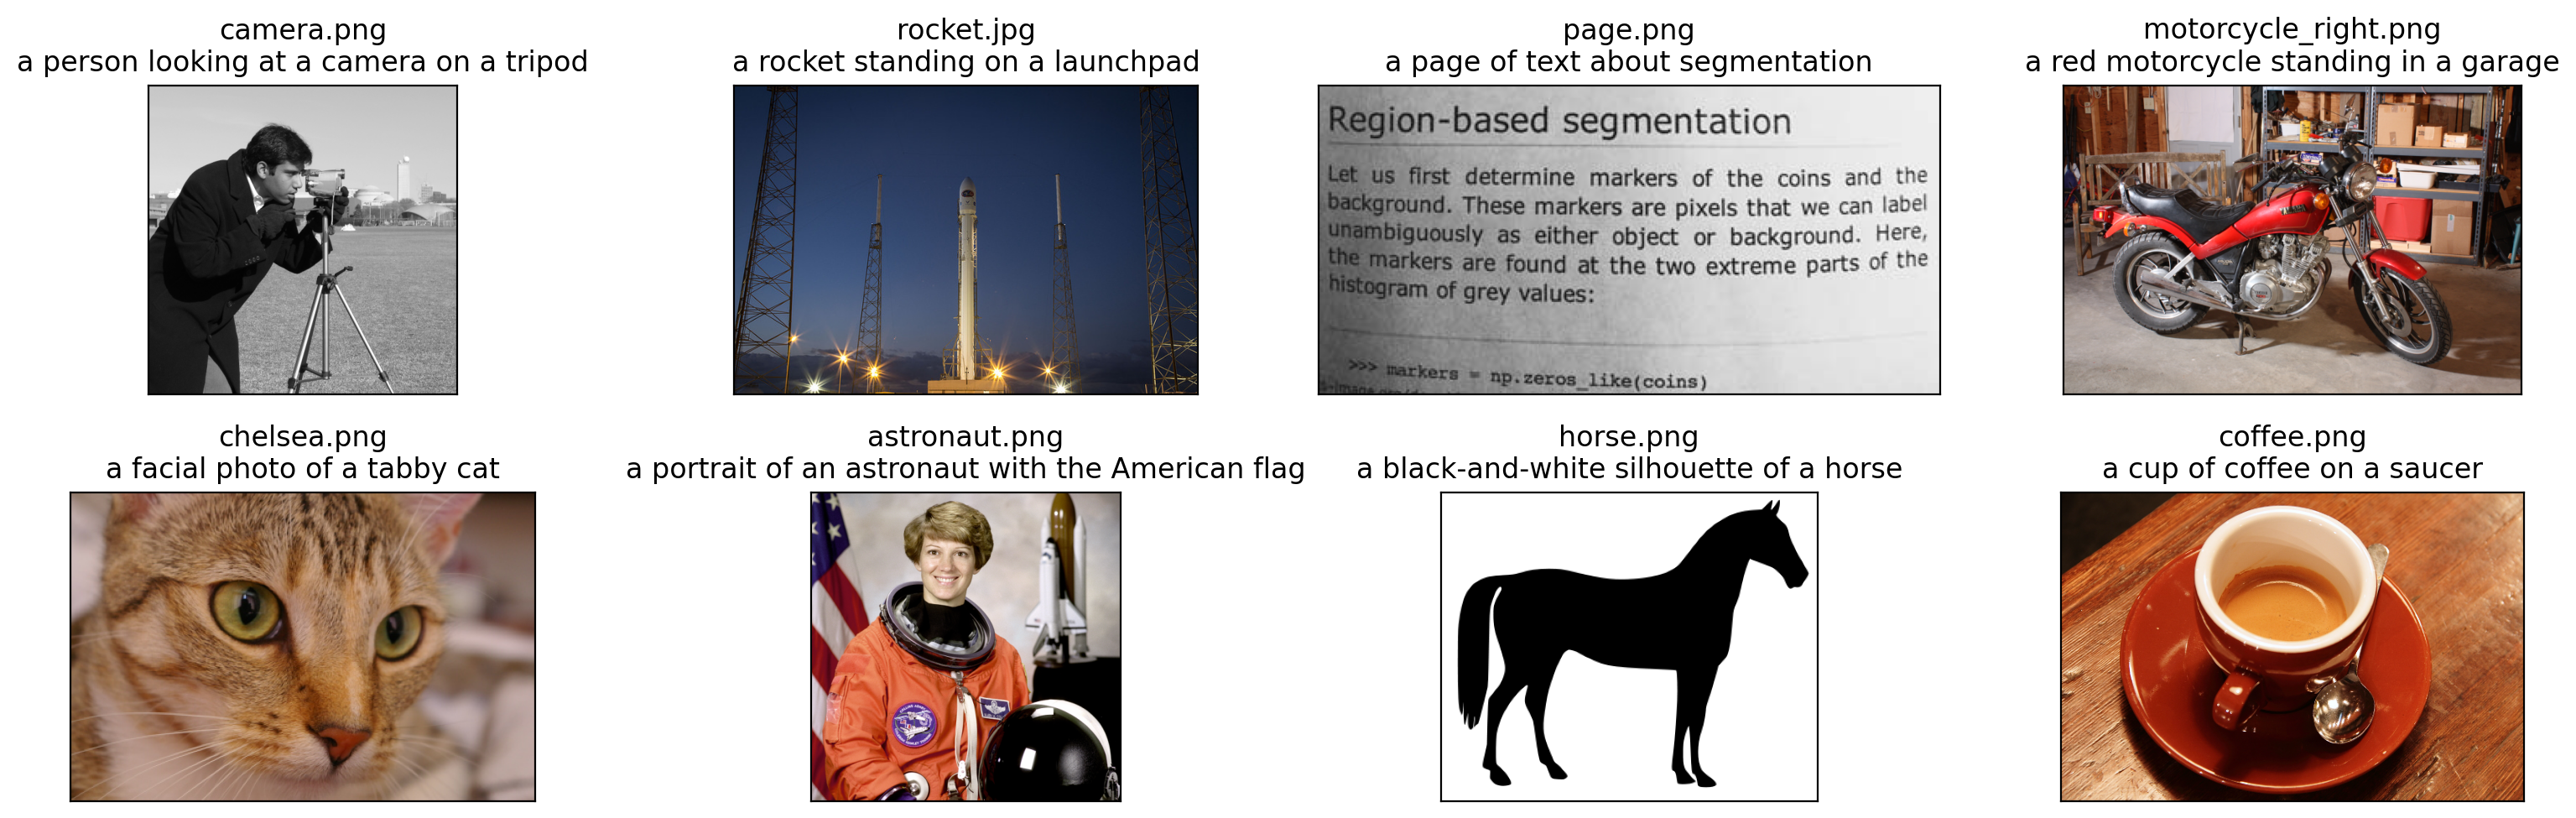

In [ ]:
# Initialize lists to store original images, processed images, and corresponding text descriptions
original_images = []
images = []
texts = []

# Create a figure with a specific size for displaying images
plt.figure(figsize=(16, 5))

# Set the directory containing skimage images
image_dir = skimage.data_dir

# Loop through all image files in the directory (only .png and .jpg files)
for filename in [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg"))]:
    # Extract the name of the image (without file extension)
    name = os.path.splitext(filename)[0]

    # Check if the image name has a corresponding description, skip if not
    if name not in descriptions:
        continue

    # Build the full file path to the image
    image_path = os.path.join(image_dir, filename)

    # Open the image and convert it to RGB mode
    image = Image.open(image_path).convert("RGB")

    # Display the image in a subplot with its description as the title
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

    # Append the original image, processed image (using preprocessing function), and description to their respective lists
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

# Adjust the layout to prevent overlap of images and labels
plt.tight_layout()
# Show the plot with all the images
plt.show()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
# Convert the list of preprocessed images into a tensor by stacking them along a new dimension
image_input = torch.tensor(np.stack(images))  # Stack images to create a batch tensor

# Tokenize the descriptions by adding the prefix "This is " to each text and then converting them to tokens
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])  # Prepare tokenized text for model input


In [ ]:
# Disable gradient calculation since we are only performing inference (not training)
with torch.no_grad():
    # Pass the image input through the model to get the image feature vectors
    image_features = model.encode_image(image_input).float()  # Generate feature vectors for images

    # Pass the tokenized text descriptions through the model to get the text feature vectors
    text_features = model.encode_text(text_tokens).float()  # Generate feature vectors for text


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
# Normalize the image features by dividing each vector by its L2 norm (magnitude) to unit length
image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize along the last dimension (per image)

# Normalize the text features by dividing each vector by its L2 norm (magnitude) to unit length
text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize along the last dimension (per text)

# Compute the cosine similarity between text and image feature vectors by taking the dot product
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T  # Calculate similarity matrix


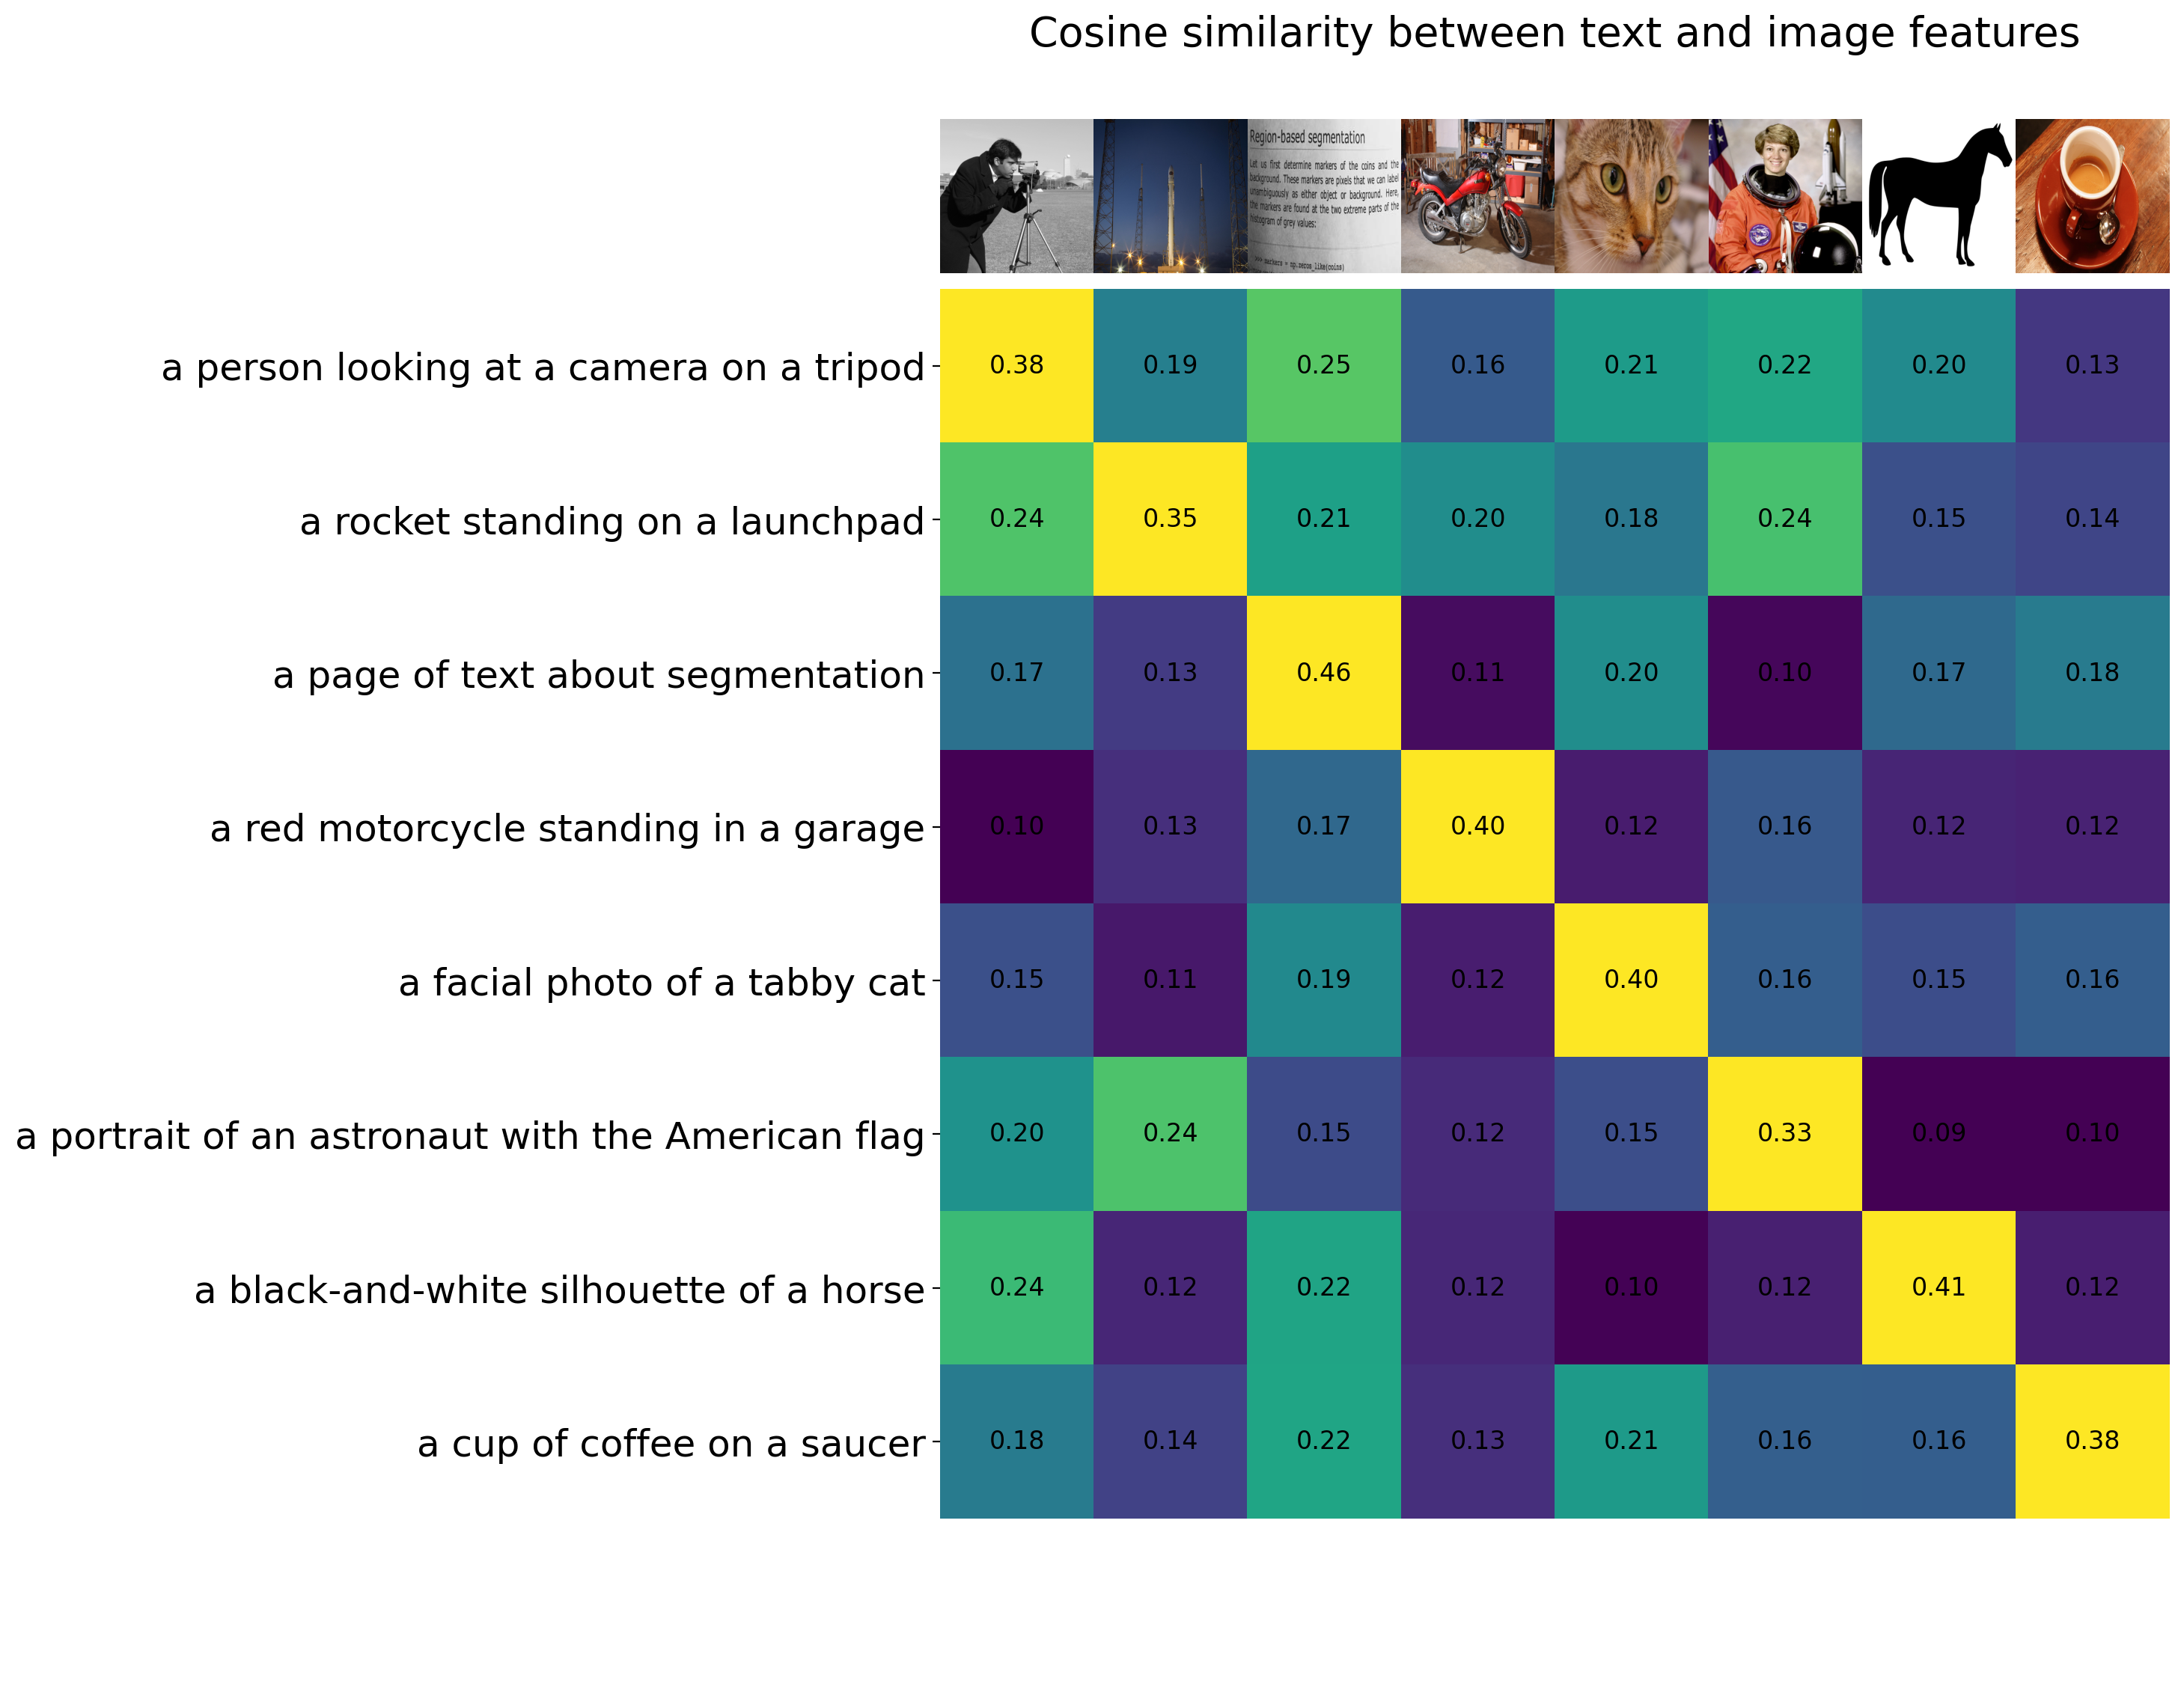

In [ ]:
# Get the number of descriptions (i.e., the number of images and texts)
count = len(descriptions)

# Create a large figure for displaying the similarity matrix and images
plt.figure(figsize=(20, 14))

# Display the similarity matrix using imshow with a specified color range
plt.imshow(similarity, vmin=0.1, vmax=0.3)  # The similarity matrix is visualized with color intensity
# Uncomment to add a color bar
# plt.colorbar()

# Set the y-axis labels as the text descriptions
plt.yticks(range(count), texts, fontsize=18)

# Hide x-axis ticks as we don't need them
plt.xticks([])

# Loop through the original images and place them over the similarity matrix
for i, image in enumerate(original_images):
    # The images are placed in the specified coordinates (extent) on the plot
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the similarity values on top of each grid cell for better understanding
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# Remove the borders (spines) around the plot
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

# Set the limits for the x and y axes
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# Add a title for the plot to explain the visualization
plt.title("Cosine similarity between text and image features", size=20)

# Display the plot
plt.show()


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
# Import the CIFAR-100 dataset from torchvision
from torchvision.datasets import CIFAR100

# Download and load the CIFAR-100 dataset, applying the preprocessing transformations
# The dataset will be cached in the user's home directory under ~/.cache
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


100%|██████████| 169M/169M [00:05<00:00, 29.8MB/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
# Create textual descriptions for each class in the CIFAR-100 dataset by formatting the class labels into sentences
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]  # Generate descriptive text for each class

# Tokenize the text descriptions using the pre-defined tokenizer
text_tokens = tokenizer.tokenize(text_descriptions)  # Convert the text descriptions into tokens that the model can process


In [ ]:
# Perform inference without tracking gradients (to save memory and computation)
with torch.no_grad():
    # Encode the text tokens into feature vectors using the model
    text_features = model.encode_text(text_tokens).float()

    # Normalize the text feature vectors to unit length (L2 normalization)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute the similarity scores between image features and text features
# Perform a matrix multiplication between image features and the transposed text features
# Multiply by 100 to scale the values for easier interpretation
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)  # Apply softmax to convert scores to probabilities

# Get the top 5 text predictions for each image based on the probabilities
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)  # `topk` gets the indices and values of the top 5 probabilities


In [ ]:
# Perform inference without tracking gradients (to save memory and computation)
with torch.no_grad():
    # Encode the text tokens into feature vectors using the model
    text_features = model.encode_text(text_tokens).float()

    # Normalize the text feature vectors to unit length (L2 normalization)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute the similarity scores between image features and text features
# Perform a matrix multiplication between image features and the transposed text features
# Multiply by 100 to scale the values for easier interpretation
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)  # Apply softmax to convert scores to probabilities

# Get the top 5 text predictions for each image based on the probabilities
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)  # `topk` gets the indices and values of the top 5 probabilities


Github->https://github.com/Krishna737Sharma/Data-Filtering-Network